# 주제 : imdb 탑1000의 영화 크롤링
# 목적 : 제목길이와 평점에 따른 년도 분석
# 제출처 : 

# 제목



In [1]:
# 주피터 노트북 환경설정
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats("retina")

from IPython.display import Image

from IPython.core.display import display, HTML
display(HTML("<style>.container { font-weight: bold !important; }</style>"))
display(HTML("<style>.container { width: 98% !important; }</style>"))


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['font.size'] = 12.0
plt.rcParams['font.family'] = 'Malgun Gothic'

# 데이터 분석 과정 

- 모듈 임포트 
- 데이타 수집 (학습데이타)
- 데이터 탐색
- 데이타 전처리 
- 데이터 학습 (모델화)
- 데이터 예측 (테스트데이타)
- 데이터 테스트 (정답률)
- + 시각화 화면 제시 

In [3]:
# 학습기 모듈 
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [4]:
# 학습데이터와 데스트 전용 데이터로 분할하는 메서드 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 데이터수집
#### 클로링 방법을 이용하여 수집 함
#### py 로 작성하여 됨.

In [59]:
from requests import get
from bs4 import BeautifulSoup
import csv, sqlite3, re

def create_csv():
    with open('top_1000.csv', 'w',-1, "utf-8") as csvfile:
        
        fieldnames = ['title', 'year', 'director', 'cast', 'imdb_rating']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        
        pages = [str(i) for i in range(1, 21)]
        for page in pages:
            url = 'http://www.imdb.com/search/title?groups=top_1000&sort=user_rating&view=simple&page=' + page
            response = get(url)
            
            html_soup = BeautifulSoup(response.text, 'html.parser')
           
            movie_containers = html_soup.find_all('div', class_ = 'lister-col-wrapper')
            for container in movie_containers:
                header = container.find('span', class_ = 'lister-item-header')
                info = header.find_all('span')[1]
                title = info.a.text
                people = info['title']
                director = people[:people.find('(')].strip()
                cast = people[people.find(')')+2:].strip()
                year = info.find('span', class_ = 'lister-item-year text-muted unbold').text
                match = re.search('([0-9]+)', year)
                year = year[match.start() : match.end()]
                rating = container.strong.text.strip()
                writer.writerow({'title': title, 'year': year, 'director': director, 'cast': cast, 'imdb_rating': rating})

def create_db():
    create_csv()
    conn = sqlite3.connect('top_1000.db')
    c = conn.cursor()
    c.execute('CREATE TABLE top_1000 (title, year, director, cast, imdb_rating);')
    with open('top_1000.csv', 'r', -1, "utf-8") as csv_file:
        dr = csv.DictReader(csv_file)
        to_db = [(i['title'], i['year'], i['director'], i['cast'], i['imdb_rating']) for i in dr]
    c.executemany('INSERT INTO top_1000 (title, year, director, cast, imdb_rating) VALUES (?, ?, ?, ?, ?);', to_db)
    conn.commit()
    conn.close()

create_db()

In [61]:
df = pd.read_csv('top_1000.csv')
df.head(5)

,title,year,director,cast,imdb_rating
0,The Shawshank Redemption,1994,Frank Darabont,"Tim Robbins, Morgan Freeman",9.3
1,Daeboo,1972,Francis Ford Coppola,"Marlon Brando, Al Pacino",9.2
2,Soorarai Pottru,2020,Sudha Kongara,"Suriya, Madhavan",9.1
3,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger",9.0
4,The Godfather: Part II,1974,Francis Ford Coppola,"Al Pacino, Robert De Niro",9.0


In [102]:
df.tail(5)





,title,year,director,cast,imdb_rating
995,Nuovo Cinema Paradiso,1988,Giuseppe Tornatore,"Philippe Noiret, Enzo Cannavale",8.5
996,Hotaru no haka,1988,Isao Takahata,"Tsutomu Tatsumi, Ayano Shiraishi",8.5
997,Back to the Future,1985,Robert Zemeckis,"Michael J. Fox, Christopher Lloyd",8.5
998,Once Upon a Time in the West,1968,Sergio Leone,"Henry Fonda, Charles Bronson",8.5
999,Psycho,1960,Alfred Hitchcock,"Anthony Perkins, Janet Leigh",8.5


In [107]:
df.imdb_rating
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
title          1000 non-null object
year           1000 non-null int64
director       1000 non-null object
cast           1000 non-null object
imdb_rating    1000 non-null float64
dtypes: float64(1), int64(1), object(3)
memory usage: 39.1+ KB


In [119]:
def ratingTolevel(x):
    if x >=9.0:
        return 'A'    
    elif x >=8.8 and x<9.0:
        return 'B'
    else:
        return 'C'

In [121]:
df['level'] = df.imdb_rating.map(ratingTolevel)

In [122]:
df.head()

,title,year,director,cast,imdb_rating,level,titleLen
0,The Shawshank Redemption,1994,Frank Darabont,"Tim Robbins, Morgan Freeman",9.3,A,24
1,Daeboo,1972,Francis Ford Coppola,"Marlon Brando, Al Pacino",9.2,A,6
2,Soorarai Pottru,2020,Sudha Kongara,"Suriya, Madhavan",9.1,A,15
3,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger",9.0,A,15
4,The Godfather: Part II,1974,Francis Ford Coppola,"Al Pacino, Robert De Niro",9.0,A,22


In [123]:
def numberOfTitle(x):
    titleLen = len(x)
    return titleLen

In [124]:
df['titleLen'] = df.title.map(numberOfTitle)
    

In [125]:
df.head()

,title,year,director,cast,imdb_rating,level,titleLen
0,The Shawshank Redemption,1994,Frank Darabont,"Tim Robbins, Morgan Freeman",9.3,A,24
1,Daeboo,1972,Francis Ford Coppola,"Marlon Brando, Al Pacino",9.2,A,6
2,Soorarai Pottru,2020,Sudha Kongara,"Suriya, Madhavan",9.1,A,15
3,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger",9.0,A,15
4,The Godfather: Part II,1974,Francis Ford Coppola,"Al Pacino, Robert De Niro",9.0,A,22


In [129]:
def yearToDecade(x):
    if x >=2000:
        return '21c'    
    elif x >=1990 and x<2000:
        return '90s'
    elif x >=1980 and x<1990:
        return '80s'
    elif x >=1970 and x<1980:
        return '70s'
    else:
        return '60s'

In [131]:
df['decade'] = df.year.map(yearToDecade)

In [132]:
df.head()

,title,year,director,cast,imdb_rating,level,titleLen,decade
0,The Shawshank Redemption,1994,Frank Darabont,"Tim Robbins, Morgan Freeman",9.3,A,24,90s
1,Daeboo,1972,Francis Ford Coppola,"Marlon Brando, Al Pacino",9.2,A,6,70s
2,Soorarai Pottru,2020,Sudha Kongara,"Suriya, Madhavan",9.1,A,15,21c
3,The Dark Knight,2008,Christopher Nolan,"Christian Bale, Heath Ledger",9.0,A,15,21c
4,The Godfather: Part II,1974,Francis Ford Coppola,"Al Pacino, Robert De Niro",9.0,A,22,70s


In [160]:
df['decade'].unique()

array(['90s', '70s', '21c', '60s', '80s'], dtype=object)

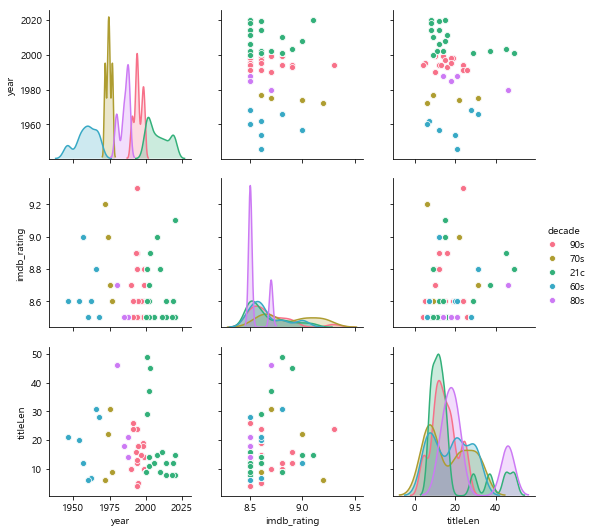

In [161]:
sns.pairplot(df, hue="decade", palette="husl")

# 데이타 전처리 

In [163]:
X = df[["titleLen","imdb_rating"]]
y = df["decade"]

In [164]:
X.columns

Index(['titleLen', 'imdb_rating'], dtype='object')

In [165]:
y.index

RangeIndex(start=0, stop=1000, step=1)

### 학습 전용과 테스트 전용 분리하기 

- 학습데이터와 데스트 전용 데이터로 분할하는 메서드 
- 임포트 
    - from sklearn.model_selection import train_test_split

```
    train_test_split( data, label, 
                       test_size=float, train_size=float, 
                        shuffle=True/False)
```                    

In [166]:
from sklearn.model_selection import train_test_split

In [167]:
X_train, X_test, y_train, y_test \
    = train_test_split( X, y, test_size = 0.25, 
                         train_size = 0.75, 
                         shuffle = True)

In [168]:
X_train.shape, X_test.shape,

((750, 2), (250, 2))

In [169]:
y_train.shape, y_test.shape

((750,), (250,))

In [170]:
X_train.head()

,titleLen,imdb_rating
369,12,8.6
351,6,9.2
405,12,9.0
83,8,8.5
979,7,8.6


### 데이타 학습  : 모델링

In [171]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [172]:
model = SVC()
model.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [173]:
model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [174]:
y_pred = model.predict(X_test)
y_pred

array(['90s', '90s', '60s', '70s', '21c', '80s', '21c', '90s', '90s',
       '90s', '90s', '90s', '90s', '90s', '80s', '60s', '90s', '90s',
       '21c', '60s', '90s', '90s', '21c', '90s', '90s', '21c', '90s',
       '21c', '60s', '21c', '90s', '21c', '21c', '90s', '21c', '21c',
       '90s', '21c', '90s', '21c', '90s', '80s', '90s', '80s', '90s',
       '90s', '60s', '21c', '21c', '90s', '90s', '60s', '90s', '60s',
       '90s', '60s', '21c', '21c', '90s', '60s', '90s', '21c', '90s',
       '90s', '21c', '21c', '70s', '60s', '21c', '90s', '60s', '90s',
       '21c', '90s', '21c', '90s', '21c', '21c', '90s', '90s', '90s',
       '21c', '90s', '21c', '21c', '90s', '21c', '90s', '90s', '90s',
       '60s', '80s', '21c', '21c', '60s', '21c', '60s', '60s', '90s',
       '21c', '21c', '60s', '21c', '21c', '90s', '21c', '21c', '60s',
       '90s', '21c', '21c', '90s', '21c', '90s', '60s', '90s', '60s',
       '21c', '90s', '21c', '60s', '90s', '70s', '90s', '60s', '21c',
       '60s', '21c',

In [175]:
df.tail()

,title,year,director,cast,imdb_rating,level,titleLen,decade
995,Nuovo Cinema Paradiso,1988,Giuseppe Tornatore,"Philippe Noiret, Enzo Cannavale",8.5,C,21,80s
996,Hotaru no haka,1988,Isao Takahata,"Tsutomu Tatsumi, Ayano Shiraishi",8.5,C,14,80s
997,Back to the Future,1985,Robert Zemeckis,"Michael J. Fox, Christopher Lloyd",8.5,C,18,80s
998,Once Upon a Time in the West,1968,Sergio Leone,"Henry Fonda, Charles Bronson",8.5,C,28,60s
999,Psycho,1960,Alfred Hitchcock,"Anthony Perkins, Janet Leigh",8.5,C,6,60s


In [179]:
model.predict([[10, 9.2]])

array(['90s'], dtype=object)

### 데이터 예측 

In [180]:
model.predict([[30, 8.7]])

array(['21c'], dtype=object)

In [181]:
model.predict([[5, 9.0]])

array(['90s'], dtype=object)

In [182]:
model.predict([[5, 8.5]])

array(['90s'], dtype=object)

In [183]:
model.predict([[30, 9.7]])

array(['21c'], dtype=object)

### 결과 확인 

metrics.accuracy_score(label, clf.predict(data))

In [184]:
from sklearn.metrics import mean_squared_error, accuracy_score

In [185]:
print("정답률 = " , accuracy_score(y_test, y_pred))

정답률 =  0.84
